<a href="https://colab.research.google.com/github/caio10012/Estudo_Python/blob/main/SOM/Self_Organizing_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/valmirf/redes_neurais_pos.git

Cloning into 'redes_neurais_pos'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 120 (delta 11), reused 1 (delta 0), pack-reused 90 (from 1)
Receiving objects: 100% (120/120), 16.66 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (35/35), done.


# Self-Organizing Maps Network

Código exemplo da rede neural SOM.

Código adaptado do site:

http://blog.yhat.com/posts/self-organizing-maps-2.html

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn import preprocessing


##Configuração da SOM

Escolhe:
1. Tamanho do mapa da SOM: X e Y
2. Número de iterações
3. Taxa de aprendizado
4. Tipo de normalização dos dados
5. Largura inicial (Sigma)
6. Constante de tempo que descresce com o tempo

In [3]:
#Tamanho do mapa
X = 5
Y = 5
network_dimensions = np.array([X, Y])


n_iterations = 10000
#taxa de aprendizado
init_learning_rate = 0.1

#Normalização dos dados
normalize_data = True
# se True, normaliza em relação a toda a base de dados
# se False, normaliza entre [0 1] levando em conta cada coluna
normalize_by_column = False

#cria raio inicial de acordo com o tamanho inicial do mapa da SOM
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2

#constante de tempo que decai com o tempo
time_constant = n_iterations / np.log(init_radius)

## Carrega base de dados

Carrega base de dados e retorna os dados normalizados.

Note que não há divisão entre treinamento e teste, pois se trata de um problema não supervisionado. Toda a base de dados é utilizada pra treinar o modelo.

In [4]:
#carrega a base de dados
def load_data(url, normalize_data,normalize_by_column):
    df = pd.read_csv(url,  header=None)
    #remove a ultima coluna (dados)
    data = df[df.columns[:-1]]

    #retorna a última coluna (rótulos)
    labels = df[df.columns[-1]]

    # check if data needs to be normalised
    if normalize_data:
      if normalize_by_column:
        # normalise along each column
        col_maxes = data.max(axis=0)
        normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
      else:
        # normalise entire dataset
        normalized_data = (data - data.min()) / (data.max() - data.min())

    return normalized_data, labels


Rede Neural SOM

In [11]:
def find_bmu(t, net, m):
    min_dist = float('inf')
    bmu_idx = None
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((t - w) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y], dtype=int)  # Corrigido
    return net[bmu_idx[0], bmu_idx[1], :], bmu_idx

In [6]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [7]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [8]:
#neighborhood
def compute_neighborhood(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

Aprendizado SOM

## Algoritmo da rede SOM


Etapa 0: posicione aleatoriamente os neurônios no mapa da rede SOM.

Etapa 1: selecione um exemplo da base de dados, aleatoriamente ou sistematicamente no conjunto de dados

Etapa 2: encontre o neurônio mais próximo do ponto de dados escolhido. Esse neurônio é chamado de Unidade de Melhor Similaridade (BMU - Best Unit Matching).

Etapa 3: Mova a BMU para mais perto desse ponto de dados. A distância movida pela BMU é determinada por uma taxa de aprendizado, que diminui após cada iteração.

Etapa 4: aproxime também os vizinhos da BMU desse ponto de dados, com os vizinhos mais distantes se movendo menos. Os vizinhos são identificados usando um raio ao redor da BMU (função de vizinhança), e o valor desse raio diminui após cada iteração.

Etapa 5: atualize a taxa de aprendizado e o raio da BMU, antes de repetir as etapas 1 a 4. Repita essas etapas até que as posições dos neurônios tenham sido estabilizadas.

In [12]:
local = 'redes_neurais_pos/RBF/iris.csv'

data,labels = load_data(local, normalize_data,normalize_by_column)

# pega tamanho da base de dados
m = data.shape[1]
n = data.shape[0]

#transforma rótulos do conjunto de treinamento em numeros pra mostrar no mapa
le = preprocessing.LabelEncoder()
le.fit(labels.values)
training_labels_transformed = le.transform(labels.values)
c = le.classes_

label_map = np.zeros((X,Y,len(c)))
# inicialização dos pesos m=dimensional pra cada neurônio da matriz SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

for i in range(n_iterations):

    #print('Iteration %d' % i)

    #seleciona um exemplo aleatoriamente da base de dados
    random_example = np.random.randint(0, n)
    t = data.iloc[random_example].values.reshape(np.array([m, 1]))

    #calcula neurônio mais próximo a este exemplo (BMU)
    bmu, bmu_idx = find_bmu(t, net, m)

    #seleciona a classe do exemplo (Apenas pra vias de informação no mapa)
    class_index = list(c).index(labels[random_example])

    lab = label_map[bmu_idx[0],bmu_idx[1]]
    lab[class_index] = lab[class_index]+1
    #associa o neurônio a esta classe
    label_map[bmu_idx[0],bmu_idx[1]] = lab

    # Decresce os parâmetros da SOM
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)

    # Atualiza o vetor de Pesos da rede SOM para todos os neurônios da rede
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # calcula a distância do neurônio ao neurônio vencedor
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # se distância está dentro do raio estipulado r^2
            if w_dist <= r**2:
                # calcula a função de vizinhança
                influence = compute_neighborhood(w_dist, r)
                # atualiza os pesos
                # w(t+1) = w(t) + (learning rate * h * distancia)
                new_w = w + (l * influence * (t - w))
                # coloca o novo peso na rede na posição X,Y
                net[x, y, :] = new_w.reshape(1, m)

## Visualiza o mapa criado

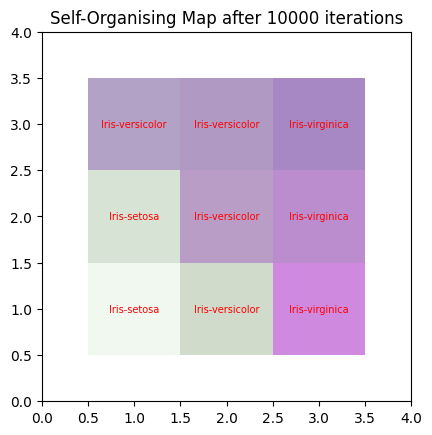

In [13]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        #print(net[x-1,y-1,:])
        m = label_map[x-1,y-1]
        name_class = c[np.argmax(m)]
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none',label='sdsad'))
        ax.text(x,y, name_class,
         horizontalalignment='center', verticalalignment='center',
         fontsize=7, color='red')
plt.show()

#Mini-Projeto rede SOM:

DATA DE ENTREGA: 02/12/2020


1. Execute a Redes Neurais SOM acima com a base de dados Iris. Mostre 5 configurações de tamanho de mapa diferentes.

<ipython-input-42-c6cda402f063>:66: RuntimeWarning: divide by zero encountered in scalar divide
  time_constant = n_iterations / np.log(init_radius)


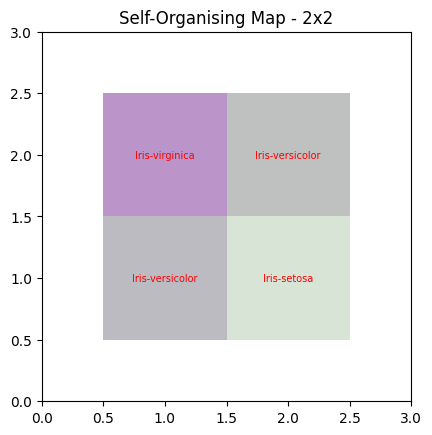

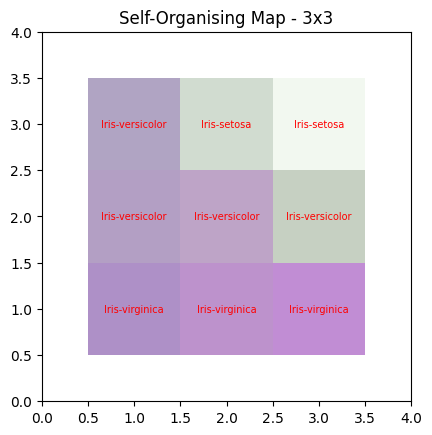

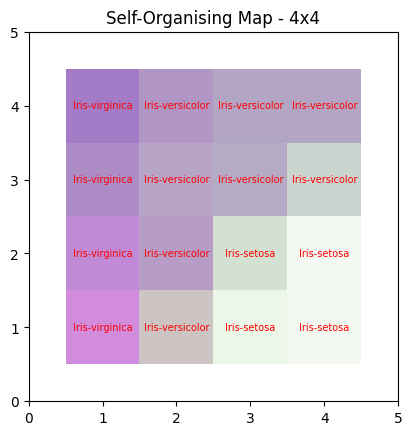

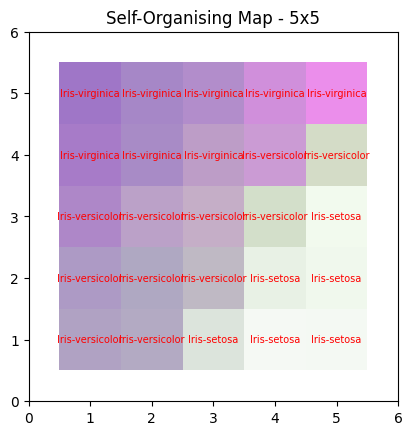

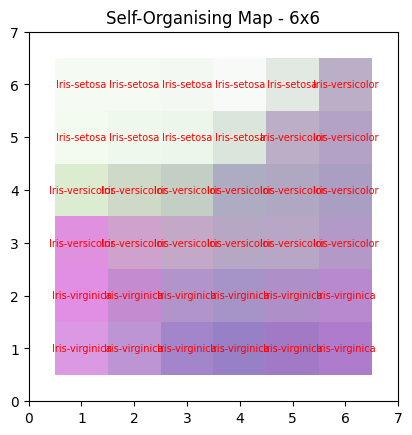

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn import preprocessing

# Funções fornecidas pelo professor
def load_data(url, normalize_data, normalize_by_column):
    df = pd.read_csv(url, header=None)
    data = df[df.columns[:-1]]
    labels = df[df.columns[-1]]

    if normalize_data:
        if normalize_by_column:
            col_maxes = data.max(axis=0)
            normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
        else:
            normalized_data = (data - data.min()) / (data.max() - data.min())

    return normalized_data, labels

def find_bmu(t, net, m):
    min_dist = float('inf')
    bmu_idx = None
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((t - w) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y], dtype=int)
    return net[bmu_idx[0], bmu_idx[1], :], bmu_idx

def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def compute_neighborhood(distance, radius):
    return np.exp(-distance / (2 * (radius**2)))

# Base de dados Iris
local = 'redes_neurais_pos/RBF/iris.csv'
normalize_data = True
normalize_by_column = False
n_iterations = 10000
init_learning_rate = 0.1

data, labels = load_data(local, normalize_data, normalize_by_column)
m = data.shape[1]
n = data.shape[0]

le = preprocessing.LabelEncoder()
le.fit(labels.values)
training_labels_transformed = le.transform(labels.values)
c = le.classes_

# Tamanhos de mapa a serem testados
map_sizes = [(2, 2), (3, 3), (4, 4), (5, 5),(6,6)]

# Função para treinar e visualizar a SOM
def train_and_visualize_som(map_size, data, labels, n_iterations, init_learning_rate, c, m):
    network_dimensions = np.array(map_size)
    init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
    time_constant = n_iterations / np.log(init_radius)
    net = np.random.random((network_dimensions[0], network_dimensions[1], m))
    label_map = np.zeros((map_size[0], map_size[1], len(c)))

    for i in range(n_iterations):
        random_example = np.random.randint(0, n)
        t = data.iloc[random_example].values.reshape(np.array([m, 1]))
        bmu, bmu_idx = find_bmu(t, net, m)
        class_index = list(c).index(labels[random_example])
        lab = label_map[bmu_idx[0], bmu_idx[1]]
        lab[class_index] = lab[class_index] + 1
        label_map[bmu_idx[0], bmu_idx[1]] = lab
        r = decay_radius(init_radius, i, time_constant)
        l = decay_learning_rate(init_learning_rate, i, n_iterations)

        for x in range(net.shape[0]):
            for y in range(net.shape[1]):
                w = net[x, y, :].reshape(m, 1)
                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                if w_dist <= r**2:
                    influence = compute_neighborhood(w_dist, r)
                    new_w = w + (l * influence * (t - w))
                    net[x, y, :] = new_w.reshape(1, m)

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, net.shape[0] + 1))
    ax.set_ylim((0, net.shape[1] + 1))
    ax.set_title(f'Self-Organising Map - {map_size[0]}x{map_size[1]}')

    for x in range(1, net.shape[0] + 1):
        for y in range(1, net.shape[1] + 1):
            m = label_map[x-1, y-1]
            name_class = c[np.argmax(m)]
            ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                         facecolor=net[x-1, y-1, :],
                         edgecolor='none'))
            ax.text(x, y, name_class,
             horizontalalignment='center', verticalalignment='center',
             fontsize=7, color='red')
    plt.show()

# Treina e visualiza a SOM para diferentes tamanhos de mapa
for map_size in map_sizes:
    train_and_visualize_som(map_size, data, labels, n_iterations, init_learning_rate, c, m)


2. Calcule a distância de Manhatan no lugar da euclidiana. Mostre os mesmos 5 mapas da questão anterior


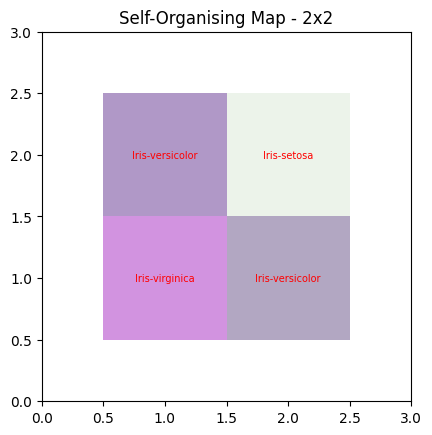

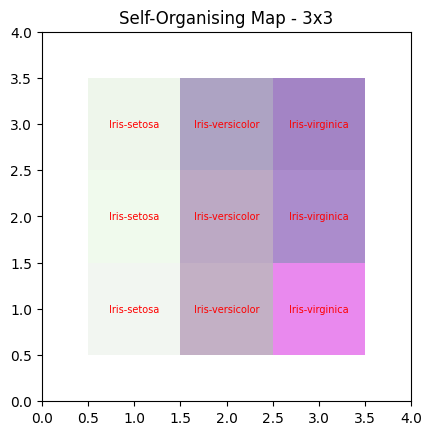

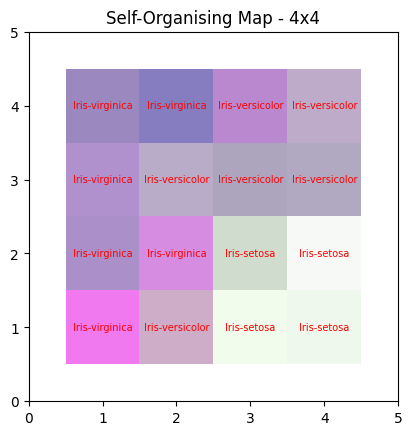

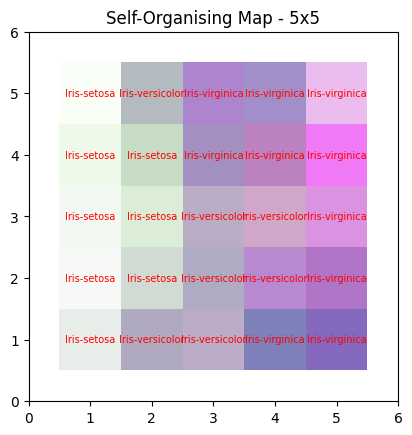

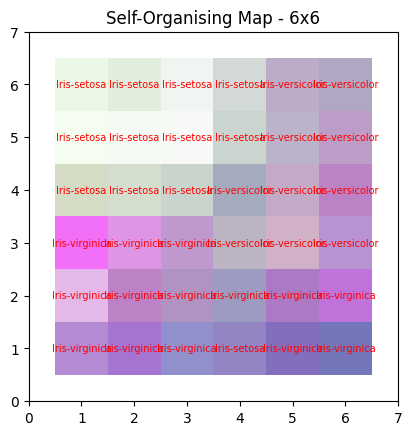

In [43]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn import preprocessing
from minisom import MiniSom

# Funções fornecidas pelo professor
def load_data(url, normalize_data, normalize_by_column):
    df = pd.read_csv(url, header=None)
    data = df[df.columns[:-1]]
    labels = df[df.columns[-1]]

    if normalize_data:
        if normalize_by_column:
            col_maxes = data.max(axis=0)
            normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
        else:
            normalized_data = (data - data.min()) / (data.max() - data.min())

    return normalized_data, labels

# Base de dados Iris
local = 'redes_neurais_pos/RBF/iris.csv'
normalize_data = True
normalize_by_column = False

data, labels = load_data(local, normalize_data, normalize_by_column)

# Normalizando os dados
data = data.values

le = preprocessing.LabelEncoder()
le.fit(labels.values)
training_labels_transformed = le.transform(labels.values)
c = le.classes_

# Tamanhos de mapa a serem testados
map_sizes = [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]

# Função para treinar e visualizar a SOM
def train_and_visualize_som(map_size, data, labels, c):
    som = MiniSom(map_size[0], map_size[1], data.shape[1], sigma=1.0, learning_rate=0.5,
                  neighborhood_function='gaussian', activation_distance='manhattan')
    som.random_weights_init(data)
    som.train_random(data, 10000)

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, som.get_weights().shape[0] + 1))
    ax.set_ylim((0, som.get_weights().shape[1] + 1))
    ax.set_title(f'Self-Organising Map - {map_size[0]}x{map_size[1]}')

    label_map = np.zeros((map_size[0], map_size[1], len(c)))
    for i, x in enumerate(data):
        w = som.winner(x)
        label_map[w[0], w[1], training_labels_transformed[i]] += 1

    for x in range(1, som.get_weights().shape[0] + 1):
        for y in range(1, som.get_weights().shape[1] + 1):
            m = label_map[x-1, y-1]
            name_class = c[np.argmax(m)]
            ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                         facecolor=som.get_weights()[x-1, y-1, :],
                         edgecolor='none'))
            ax.text(x, y, name_class,
             horizontalalignment='center', verticalalignment='center',
             fontsize=7, color='red')
    plt.show()

# Treina e visualiza a SOM para diferentes tamanhos de mapa
for map_size in map_sizes:
    train_and_visualize_som(map_size, data, labels, c)


In [18]:
!pip install minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=3fb086b984a293dff5a1e4bbb55f36826d99ce0681171ab042350e9441bc438b
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


3. Apresente os mesmos mapas da primeira questão pra outra base de dados de sua escolha. (Ex: Wine, Diabetes, Breast-Cancer, Letter, Digits)




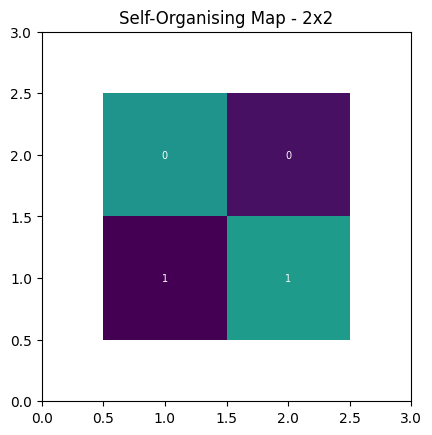

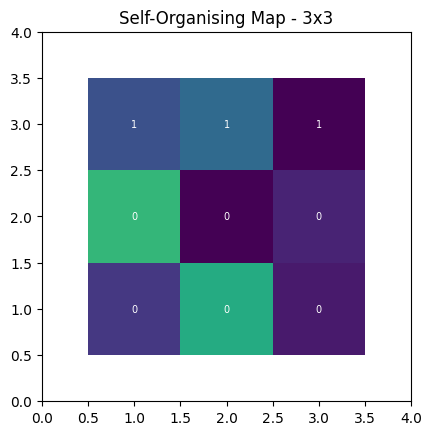

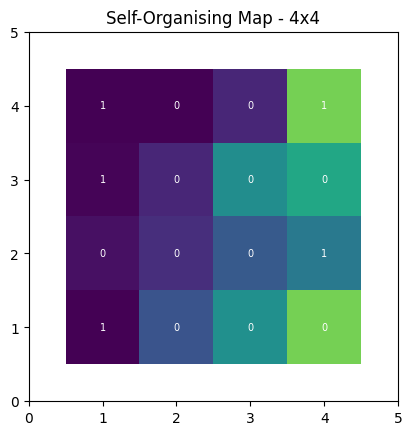

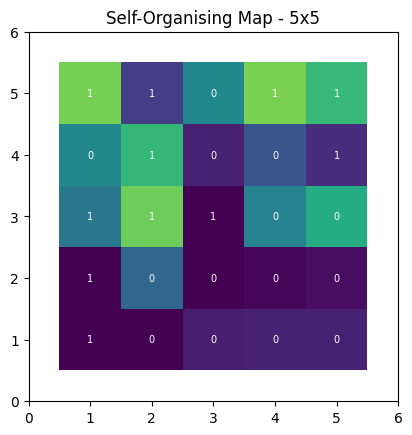

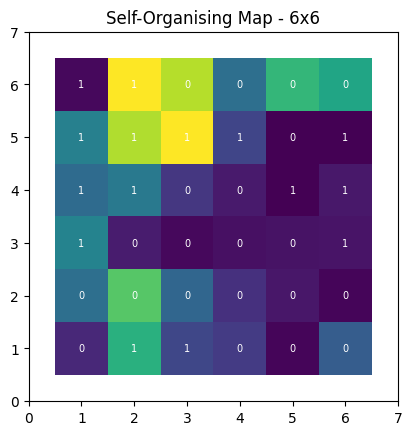

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn import preprocessing
from minisom import MiniSom

# Funções fornecidas pelo professor
def load_data(url, normalize_data, normalize_by_column):
    df = pd.read_csv(url, header=None)
    data = df[df.columns[:-1]]
    labels = df[df.columns[-1]]

    if normalize_data:
        if normalize_by_column:
            col_maxes = data.max(axis=0)
            normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
        else:
            normalized_data = (data - data.min()) / (data.max() - data.min())

    return normalized_data, labels

# Base de dados Diabetes
local = 'redes_neurais_pos/RBF/diabetes.csv'
normalize_data = True
normalize_by_column = False

data, labels = load_data(local, normalize_data, normalize_by_column)

# Normalizando os dados
data = data.values

le = preprocessing.LabelEncoder()
le.fit(labels.values)
training_labels_transformed = le.transform(labels.values)
c = le.classes_

# Tamanhos de mapa a serem testados
map_sizes = [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]

# Função para gerar cores baseadas nos pesos da SOM
def generate_colors(weights):
    norm_weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm_weights)
    return colors

# Função para treinar e visualizar a SOM
def train_and_visualize_som(map_size, data, labels, c):
    som = MiniSom(map_size[0], map_size[1], data.shape[1], sigma=1.0, learning_rate=0.5,
                  neighborhood_function='gaussian', activation_distance='manhattan')
    som.random_weights_init(data)
    som.train_random(data, 10000)

    # Mapa de rótulos
    label_map = np.zeros((map_size[0], map_size[1], len(c)))
    for i, x in enumerate(data):
        w = som.winner(x)
        label_map[w[0], w[1], training_labels_transformed[i]] += 1

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, som.get_weights().shape[0] + 1))
    ax.set_ylim((0, som.get_weights().shape[1] + 1))
    ax.set_title(f'Self-Organising Map - {map_size[0]}x{map_size[1]}')

    for x in range(1, som.get_weights().shape[0] + 1):
        for y in range(1, som.get_weights().shape[1] + 1):
            m = label_map[x-1, y-1]
            name_class = c[np.argmax(m)]
            facecolor = generate_colors(som.get_weights()[x-1, y-1, :])
            ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                         facecolor=facecolor[0], edgecolor='none'))
            ax.text(x, y, name_class,
             horizontalalignment='center', verticalalignment='center',
             fontsize=7, color='white')
    plt.show()

# Treina e visualiza a SOM para diferentes tamanhos de mapa
for map_size in map_sizes:
    train_and_visualize_som(map_size, data, labels, c)
